In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import plotly.express as px
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score
import warnings
import optuna
import xgboost as xgb
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")

c:\Users\ztz19\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_res=pd.DataFrame(columns=['name','score','Kappa','F1-score','precision_N',"recall_N",'f1-score_N','precision_D',"recall_D",'f1-score_D','precision_BD',"recall_BD",'f1-score_BD','line','params','AUC'])

[I 2023-01-19 10:44:14,221] A new study created in memory with name: no-name-13d96f2c-44a5-45a1-9745-261e76fbe254
[I 2023-01-19 10:44:16,567] Trial 0 finished with value: 0.670560224089636 and parameters: {'booster': 'gbtree', 'lambda': 2.2581611629953145e-08, 'alpha': 2.1094883072071714e-08, 'subsample': 0.23378240308897427, 'colsample_bytree': 0.9379963068194892, 'max_depth': 9, 'min_child_weight': 7, 'eta': 1.1084127374256844e-07, 'gamma': 2.0018908586916783e-07, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.670560224089636.
[I 2023-01-19 10:44:16,935] Trial 1 finished with value: 0.6482913165266107 and parameters: {'booster': 'gblinear', 'lambda': 7.486187059271871e-05, 'alpha': 0.012197102968648278, 'subsample': 0.29094771146919485, 'colsample_bytree': 0.3419607219031827}. Best is trial 0 with value: 0.670560224089636.
[I 2023-01-19 10:44:18,126] Trial 2 finished with value: 0.6907703081232492 and parameters: {'booster': 'gbtree', 'lambda': 1.7580151704212215e-08, 'al

              precision    recall  f1-score   support

           0       0.70      0.47      0.56        34
           1       0.89      0.97      0.93       151
           2       0.74      0.63      0.68        27

    accuracy                           0.85       212
   macro avg       0.77      0.69      0.72       212
weighted avg       0.84      0.85      0.84       212



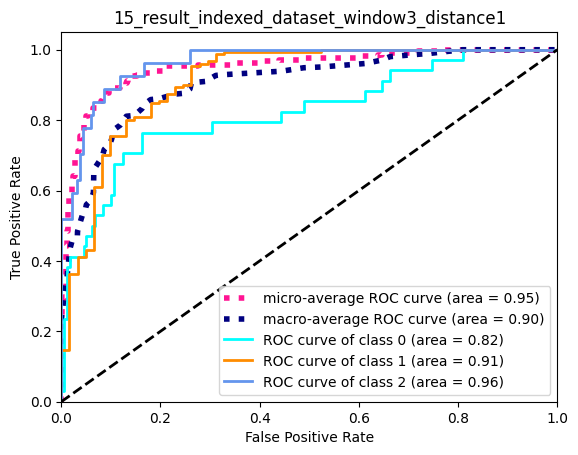

In [3]:
from pickle import FALSE

file_name = '15_result_indexed_dataset_window3_distance1.csv'
df=pd.read_csv(file_name)
str_name= file_name.split('.')
df['WTSD_latitude'].fillna(0, inplace=True)
df['WTSD_longitude'].fillna(0, inplace=True)
df_omit=df.dropna()

df_omit = df_omit[df_omit['day_of_week'] <5]
df_omit=df_omit.drop(columns='day_of_week')
df_omit["label"] = pd.factorize(df_omit["label"])[0].astype(int)
df_omit=df_omit.drop(columns='pid')
df_omit=df_omit.drop(columns='study_duration')
df_omit=df_omit.drop(columns='Unnamed: 0')
df_omit=df_omit.drop(columns='time_stamp')
y_general = df_omit['label']
x_general_1 = df_omit.drop(columns='label')

list_gereral=(list(x_general_1))
scaler = MinMaxScaler()
scaler.fit(x_general_1)
x_general_1 = scaler.transform(x_general_1)
x_general_1=pd.DataFrame(x_general_1)
x_general_1.columns=list_gereral


X_train_general, X_test_general, y_train_general, y_test_general= train_test_split(x_general_1, y_general,test_size=0.2)


list_res_temp=[]
list_res_temp.append(str_name[0])

def objective(trial):
    check_acc=0
    param = {
        "verbosity": 0,
        "objective": 'multi:softmax',
        'num_class':3,
        #'multi:softprob'
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)


    x_general_gk = X_train_general.to_numpy()
    y_general_gk = y_train_general.to_numpy()
    columns= X_train_general.columns
    #Set to ten groups--------------------------------------
    kfold = KFold(n_splits=10,shuffle=True)
    sm = SMOTE(random_state = 3,sampling_strategy='not majority')
    for train_index, test_index in kfold.split(x_general_gk):
        #Cross-tabulation of 90% of the test dataset
        
        sub_x_train_general, sub_x_test_general = x_general_gk[train_index], x_general_gk[test_index]
        sub_y_train_general, sub_y_test_general = y_general_gk[train_index], y_general_gk[test_index]
        sub_x_train_general, sub_y_train_general = sm.fit_resample(sub_x_train_general, sub_y_train_general)
        
        dtrain = xgb.DMatrix(sub_x_train_general, label=sub_y_train_general)
        dvalid = xgb.DMatrix(sub_x_test_general, label=sub_y_test_general)

        bst = xgb.train(param, dtrain)
        preds = bst.predict(dvalid)
        pred_labels = np.rint(preds)
        f1=f1_score(sub_y_test_general, pred_labels, average='micro')
        check_acc=check_acc+f1

    return (check_acc/10)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)
trial = study.best_trial

params=trial.params
model = XGBClassifier(**params)
    
model.fit(X_train_general,y_train_general)


y_pred = model.predict(X_test_general)
score=accuracy_score(y_pred,y_test_general)
list_res_temp.append(score)
list_res_temp.append(cohen_kappa_score(y_test_general, y_pred))
list_res_temp.append(f1_score(y_test_general, y_pred, average='micro'))


res_pre_f1=classification_report(y_test_general, y_pred)
print(res_pre_f1)
res_pre_f1_1=res_pre_f1.split('         ')
res_pre_f1_N=res_pre_f1_1[2].split('      ')
res_pre_f1_D=res_pre_f1_1[3].split('      ')
res_pre_f1_BD=res_pre_f1_1[4].split('      ')

list_res_temp.append(float(res_pre_f1_N[1]))
list_res_temp.append(float(res_pre_f1_N[2]))
list_res_temp.append(float(res_pre_f1_N[3]))

try:
    list_res_temp.append(float(res_pre_f1_D[1]))
    list_res_temp.append(float(res_pre_f1_D[2]))
    list_res_temp.append(float(res_pre_f1_D[3]))
except:
    res_pre_f1_D=res_pre_f1_1[4].split('      ')
    if res_pre_f1_D[0]==2:
        list_res_temp.append(float(0))
        list_res_temp.append(float(0))
        list_res_temp.append(float(0))
        res_pre_f1_BD=res_pre_f1_1[4].split('      ')
    else:
        res_pre_f1_BD=res_pre_f1_1[5].split('      ')
        list_res_temp.append(float(res_pre_f1_D[1]))
        list_res_temp.append(float(res_pre_f1_D[2]))
        list_res_temp.append(float(res_pre_f1_D[3]))


try:
    list_res_temp.append(float(res_pre_f1_BD[1]))
    list_res_temp.append(float(res_pre_f1_BD[2]))
    list_res_temp.append(float(res_pre_f1_BD[3]))
except:
    try:
        res_pre_f1_BD=res_pre_f1_1[5].split('      ')
        list_res_temp.append(float(res_pre_f1_BD[1]))
        list_res_temp.append(float(res_pre_f1_BD[2]))
        list_res_temp.append(float(res_pre_f1_BD[3]))
    except:
        res_pre_f1_BD=res_pre_f1_1[6].split('      ')
        list_res_temp.append(float(res_pre_f1_BD[1]))
        list_res_temp.append(float(res_pre_f1_BD[2]))
        list_res_temp.append(float(res_pre_f1_BD[3]))


list_res_temp.append(len(df_omit))
list_res_temp.append(params)



# Binarize the output
y_test_general = label_binarize(y_test_general, classes=[0, 1, 2])
n_classes = y_test_general.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X_test_general.shape
#x_general = np.c_[x_general, random_state.randn(n_samples, 200 * n_features)]
y_score=model.predict_proba(X_test_general)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_general[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_general.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(str_name[0])
plt.legend(loc="lower right")
plt.savefig('%s_weekday.png'%str_name[0])
plt.show()
df_pvalue=pd.DataFrame(columns=['name','pearson value','P-value'])
for i in range (len(list_gereral)):
    list_res=[]
    r = pearsonr(df_omit[list_gereral[i]],df_omit["label"])
    list_res.append(r[0])
    list_res.append(r[1])
    #list_res.insert(0,res[0][1])
    list_res.insert(0,list_gereral[i])

    df_pvalue.loc[i]=list_res
df_pvalue.to_csv('%s_weekday_pvalue.csv'%str_name[0])

list_res_temp.append(roc_auc_score(y_test_general,y_score))
df_res.loc[0]=list_res_temp
df_res.to_csv('%s_weekday_result.csv'%str_name[0])